In [1]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.regularizers import l2
import numpy as np

# this is the size of our encoded representations
encoding_dim = 6  # 6 floats 
# this is our input placeholder
input_img = Input(shape=(784,))
d = Dense(256, activation='selu')(input_img)
d = Dense(128, activation='selu')(d)
encoded = Dense(encoding_dim, activation='selu', kernel_regularizer=l2(0.01))(d)
d = Dense(128, activation='selu')(encoded)
d = Dense(256, activation='selu')(d)
decoded = Dense(784, activation='sigmoid')(d)
# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
# create a placeholder for an encoded (6-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
deco = autoencoder.layers[-3](encoded_input)
deco = autoencoder.layers[-2](deco)
deco = autoencoder.layers[-1](deco)
# create the decoder model
decoder = Model(encoded_input, deco)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Using TensorFlow backend.


In [2]:
from keras.datasets import mnist
import numpy as np
import pandas as pd
from gmm_mml import GmmMml
from keras.callbacks import TensorBoard
(x_train, y_train), (x_test, y_test) = mnist.load_data()


x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)


autoencoder.fit(x_train, x_train,
                epochs=600,
                batch_size=4096,
                shuffle=True,
                verbose=2,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

(60000, 784)
(10000, 784)
Train on 60000 samples, validate on 10000 samples
Epoch 1/600
1s - loss: 0.6056 - val_loss: 0.3822
Epoch 2/600
0s - loss: 0.3595 - val_loss: 0.3385
Epoch 3/600
0s - loss: 0.3251 - val_loss: 0.3081
Epoch 4/600
0s - loss: 0.2959 - val_loss: 0.2815
Epoch 5/600
0s - loss: 0.2735 - val_loss: 0.2634
Epoch 6/600
0s - loss: 0.2579 - val_loss: 0.2503
Epoch 7/600
0s - loss: 0.2463 - val_loss: 0.2403
Epoch 8/600
0s - loss: 0.2374 - val_loss: 0.2323
Epoch 9/600
0s - loss: 0.2302 - val_loss: 0.2258
Epoch 10/600
0s - loss: 0.2242 - val_loss: 0.2204
Epoch 11/600
0s - loss: 0.2191 - val_loss: 0.2157
Epoch 12/600
0s - loss: 0.2145 - val_loss: 0.2113
Epoch 13/600
0s - loss: 0.2101 - val_loss: 0.2070
Epoch 14/600
0s - loss: 0.2054 - val_loss: 0.2017
Epoch 15/600
0s - loss: 0.1990 - val_loss: 0.1938
Epoch 16/600
0s - loss: 0.1917 - val_loss: 0.1875
Epoch 17/600
0s - loss: 0.1864 - val_loss: 0.1833
Epoch 18/600
0s - loss: 0.1828 - val_loss: 0.1804
Epoch 19/600
0s - loss: 0.1802 - 

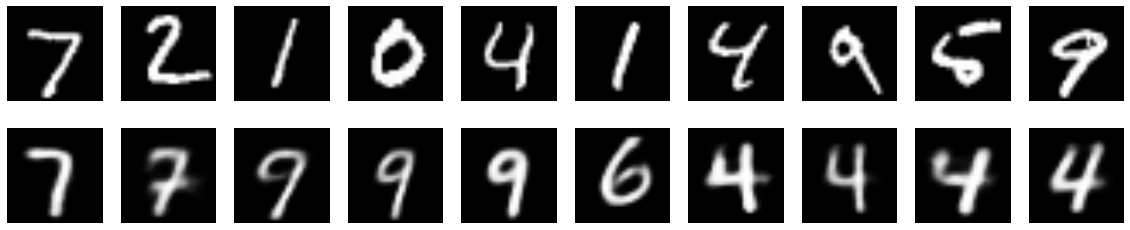

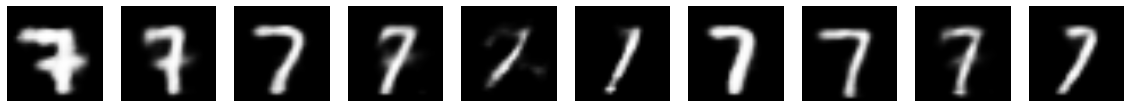

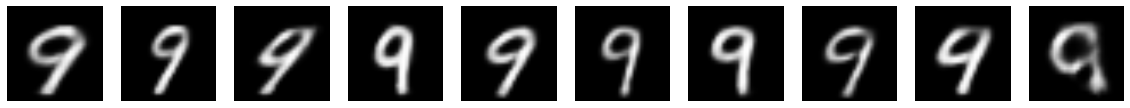

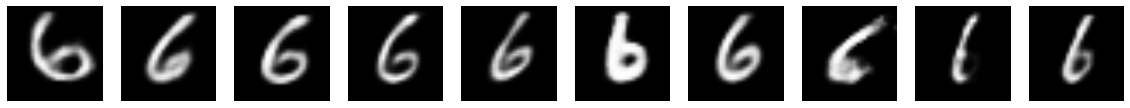

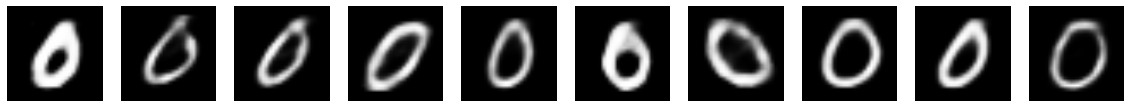

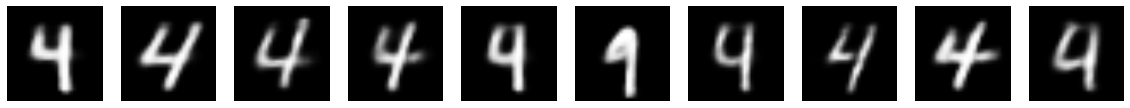

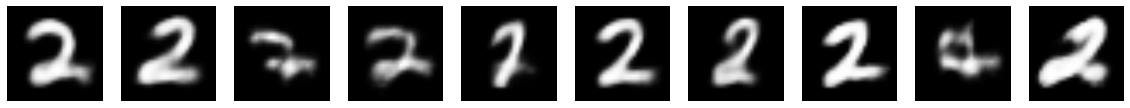

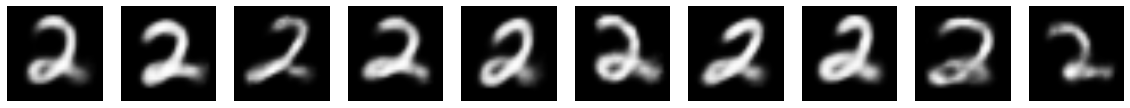

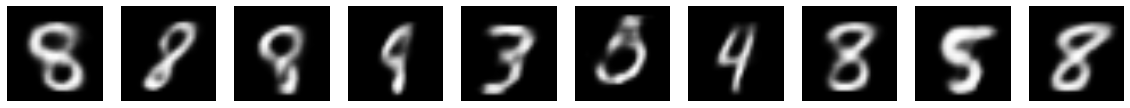

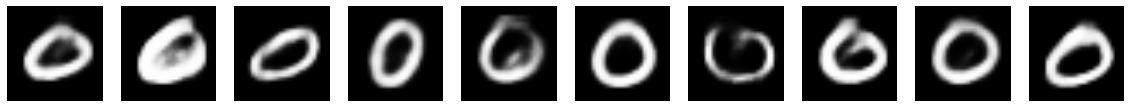

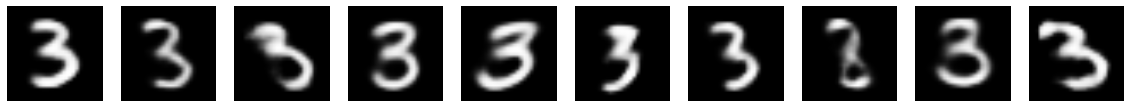

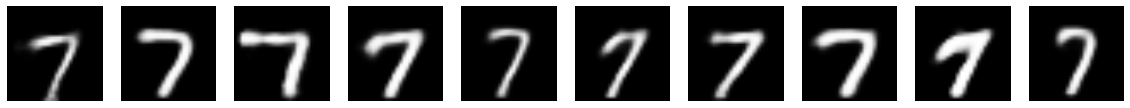

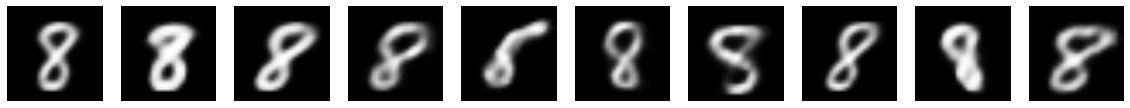

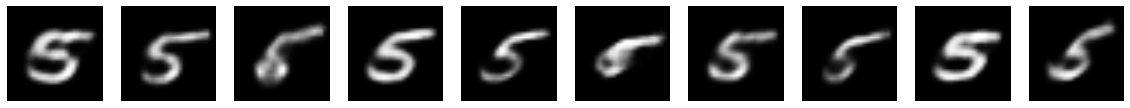

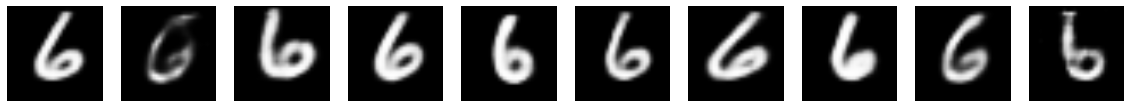

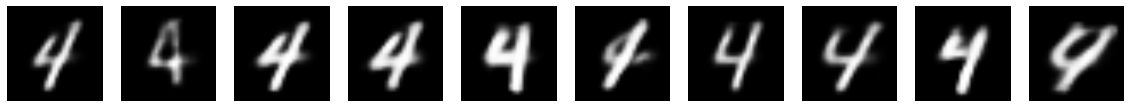

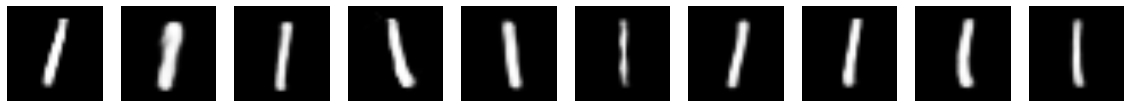

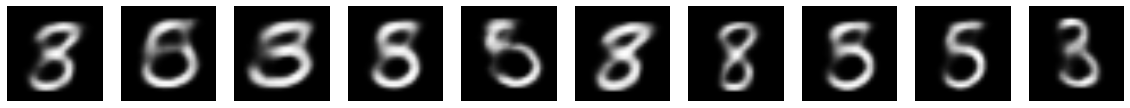

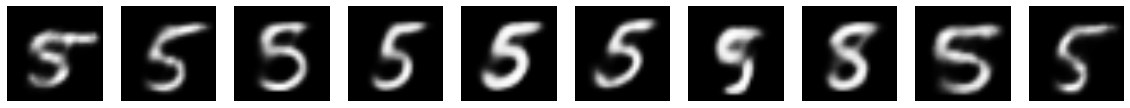

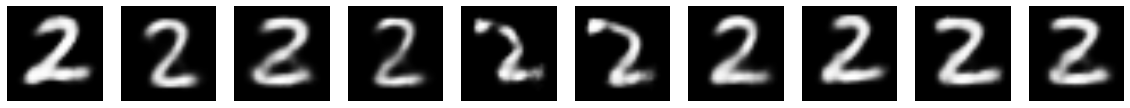

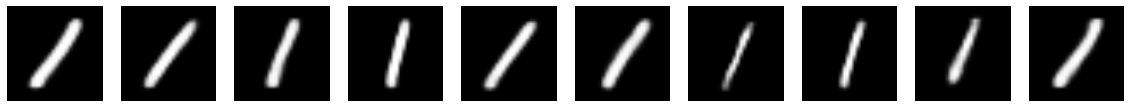

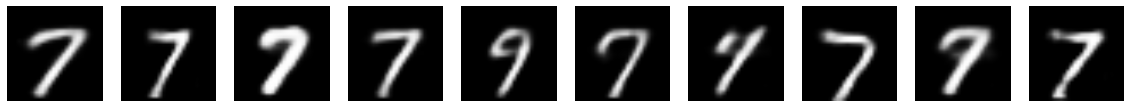

In [3]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)

clf=GmmMml()

clf.fit(encoded_imgs)

decoded_imgs = decoder.predict(clf.sample(32))


# use Matplotlib (don't ask)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

for c in range(0,clf.bestmu.shape[0]):
    samples=[]
    for i in range(0,11):
        samples.append(np.random.multivariate_normal(clf.bestmu[c],np.swapaxes(clf.bestcov,0,2)[c]))
    samples=np.array(samples)
    decoded_imgs = decoder.predict(samples)
        
    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

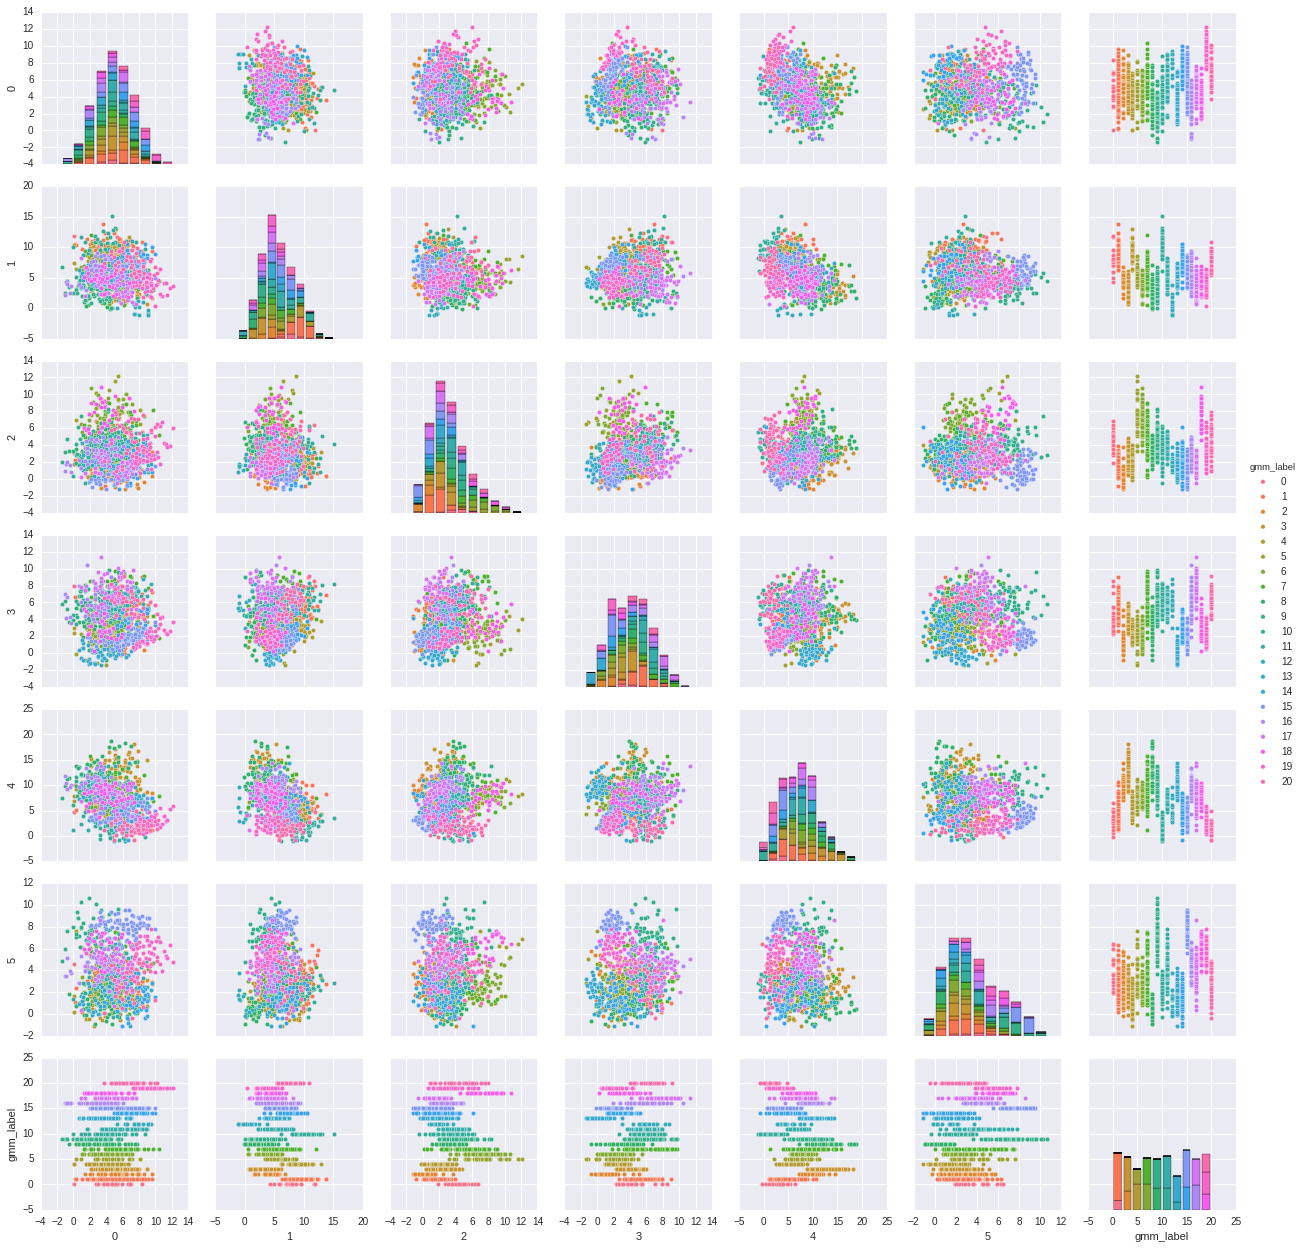

In [15]:
gmm_label=clf.predict(encoded_imgs)
enc_imgs_frame=pd.DataFrame(encoded_imgs)
enc_imgs_frame['gmm_label']=gmm_label
enc_imgs_frame.head()
g = sns.pairplot(enc_imgs_frame.sample(1000, random_state=1337), hue="gmm_label")
plt.show()

In [16]:
enc_imgs_frame=pd.DataFrame(encoded_imgs)
enc_imgs_frame['Number']=y_test
enc_imgs_frame.head()

,0,1,2,3,4,5,Number
0,3.183712,8.475207,3.962184,6.315407,-0.347904,2.105817,7
1,2.033864,4.829456,6.855589,2.548717,9.730109,6.609442,2
2,7.472386,3.842108,1.725055,0.698462,1.333443,5.403172,1
3,4.937399,4.053072,3.713273,3.244431,15.094933,3.301715,0
4,3.342302,7.165679,1.266812,2.933699,5.475688,0.170398,4


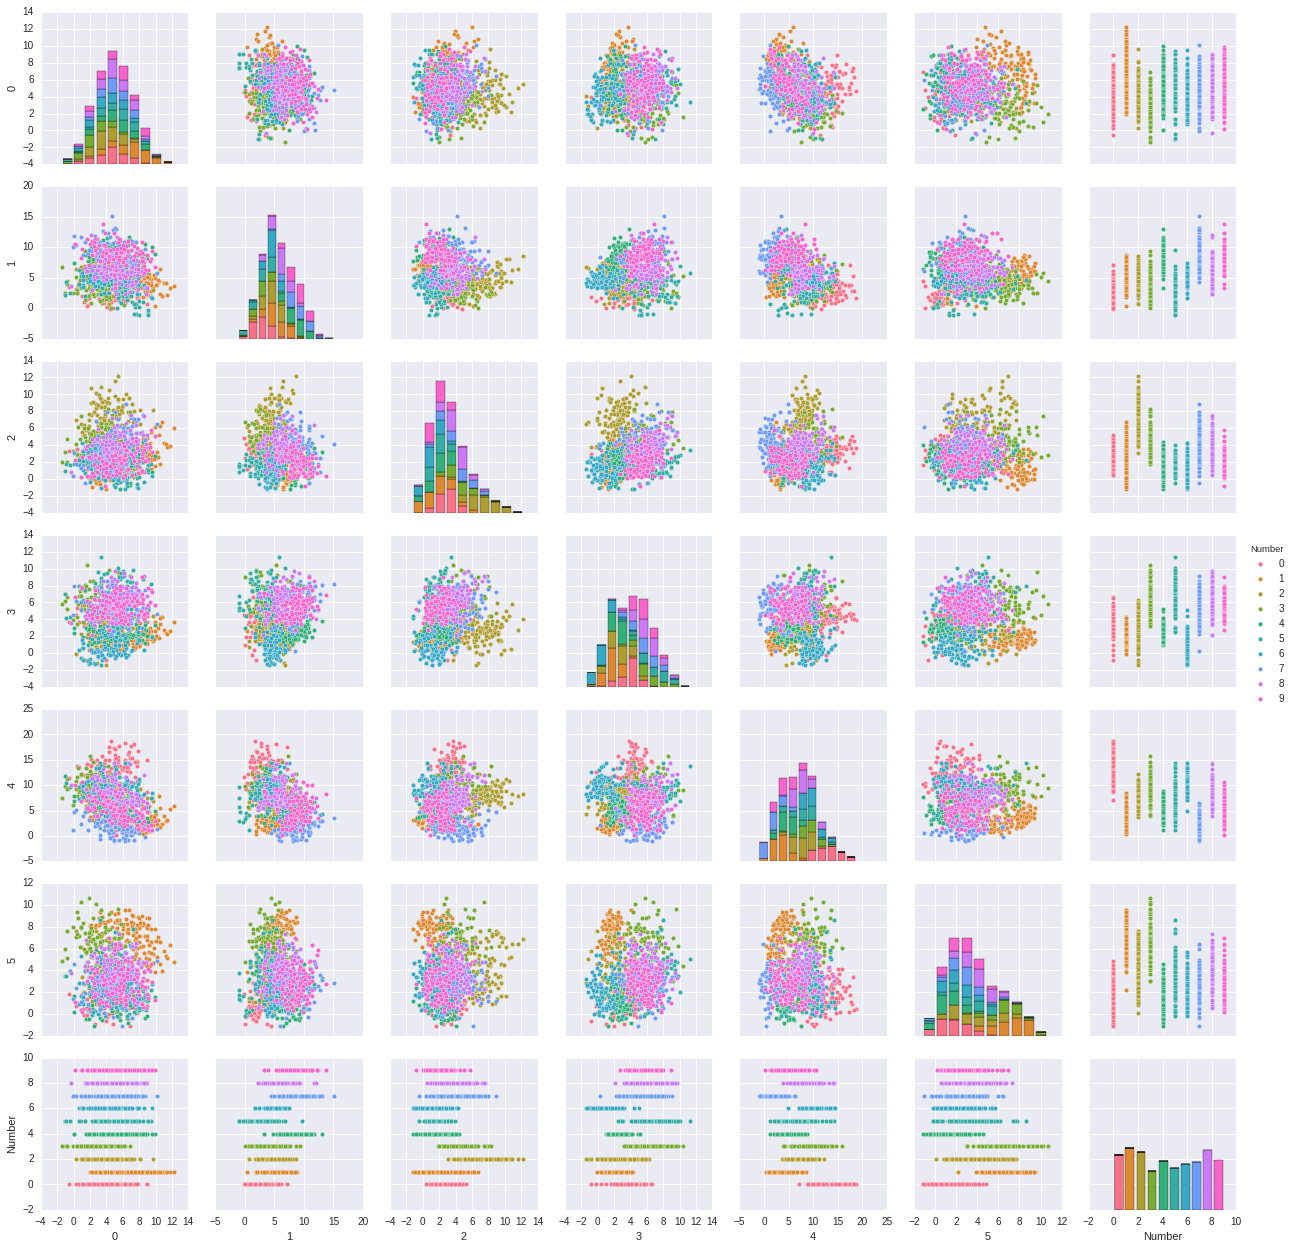

In [17]:
g = sns.pairplot(enc_imgs_frame.sample(1000, random_state=1337), hue="Number")
plt.show()